# Setup

In [13]:
import json
import requests
import pandas as pd
import numpy as np
import psycopg2
from datetime import datetime,timezone,date,timedelta
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import silhouette_score,davies_bouldin_score
from yellowbrick.cluster import KElbowVisualizer
from scipy import stats
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
import matplotlib.colors
from statsmodels.graphics import tsaplots
from sklearn.mixture import GaussianMixture
import pytz
import plotly.express as px
import calendar
from statsmodels.graphics import tsaplots
from yellowbrick.cluster import silhouette_visualizer
from sklearn.neighbors import NearestNeighbors
import math
import warnings
warnings.filterwarnings('ignore')


plt.style.use('seaborn')

# Utils

In [14]:
def to_date(x):
    """
    Function for parsing dates from strings
    
    :params:
    --------
    x: string representing date and time
    
    :Returns:
    ---------
    date: datetime object representing the parsed date in the required format
    
    """
    try:
        date =  datetime.strptime(x,"%Y-%m-%dT%H:%M:%S.%fZ[UTC]")
    except Exception:
        date =  datetime.strptime(x,"%Y-%m-%dT%H:%M:%SZ[UTC]")
    return date

def add_transformed_timestamp_col(csv_file_path,original_col="timestamp",utc_shift =3 ,save_to_csv=None):
    """
    Function for parsing the "original_col" column into datetime that is time zone aware
    
    :params:
    --------
    csv_file_path: string: representing the path to the csv file
    original_col: string name of the col to be parsed
    utc_shift: integer representing the shift from utc 
    save_to_csv: string of the path where to save the processed file with an added column called:"transformed_timestamp"
                 If None it will not save the file.
    :Returns:
    ---------
    df : the same dataframe passed as input with a new column" transformed_timestamp" which is the parsed datetime timezezone aware col
    
    """
    if isinstance(csv_file_path,pd.DataFrame):
        df = csv_file_path.copy()
        df[original_col] = pd.to_datetime(df[original_col],format ="%Y-%m-%dT%H:%M:%SZ[UTC]")
        df["value"] = df["value"].astype('float64')

    else:
        dateparse = lambda x: to_date(x) ## dateparser as lambda function
        df = pd.read_csv(csv_file_path, parse_dates=[original_col], date_parser=dateparse)
    ET = timezone(timedelta(hours=utc_shift))
    df["transformed_timestamp"]  = df[original_col].dt.tz_localize(timezone.utc).dt.tz_convert(ET)
    df["transformed_timestamp"] = df["transformed_timestamp"].dt.round("S") ## round datetime to nearest seconds

    if save_to_csv:
        df.to_csv(save_to_csv,index=False,encoding='utf-8-sig')
        print("File Saved!")
    return df

# Read Data

In [5]:
## Read data
def read_data(path_to_csv,date_columns = []):
    df = pd.read_csv(path_to_csv,parse_dates=date_columns)
    return df


# Preprocessing


In [82]:
# Define two different ways of processing and compare their results
def preprocess1(df,timestamp_col="transformed_timestamp",devices_type=1):
    devices = np.unique(df.loc[:,"device_code"])
    final_df = pd.DataFrame()
    for device in devices:
        data = df.loc[df["device_code"]==device]
        
        # substract from the energy consumption of each row the value of the previous one to get the current consumption
        data.loc[:,"energy_difference"] = data.sort_values([timestamp_col]).loc[:,"value"].diff()
        
        # get the time difference at each row in minutes
        data.loc[:,"time_difference"] = data.sort_values([timestamp_col]).loc[:,timestamp_col].diff().dt.total_seconds().div(60)
        
        if devices_type==1:
            # deal with the devices that reset at the beginning of each day
            data.loc[data["energy_difference"] <0,"energy_difference"] = data.loc[data["energy_difference"] <0,"value"]
            
        # calculate the power    
        data.loc[:,"power"]  = data.loc[:,"energy_difference"]/data.loc[:,"time_difference"]
        
        #Resample power at 10 min
        resampled_power_df = data.resample("10min",on=timestamp_col)[["power"]].mean()
        resampled_power_df.fillna(method="bfill",inplace=True)

        resampled_power_df = resampled_power_df.reset_index()
        
        #Calculate energy consumption in 10 min interval
        resampled_power_df.loc[:,"energy"] = resampled_power_df["power"] *10
        
        #Calculate hourly energy consumption
        hourly_consumption= resampled_power_df.resample("1h",on=timestamp_col).sum()
        hourly_consumption.loc[:,"device_code"]=device
        
        
        #Replace the anomaly energy values using backward fill
        hourly_consumption.loc[:,"energy_mean"] = hourly_consumption["energy"].mean()
        hourly_consumption.loc[:,"lower_limit"] = hourly_consumption["energy_mean"] - (3*hourly_consumption["energy"].std())
        hourly_consumption.loc[:,"upper_limit"] = hourly_consumption["energy_mean"] + (3*hourly_consumption["energy"].std())
        hourly_consumption.loc[(hourly_consumption["energy"]>hourly_consumption["upper_limit"]) | (hourly_consumption["energy"]<hourly_consumption["lower_limit"]),["energy"]]= np.nan
        hourly_consumption.loc[:,"anomaly"] = hourly_consumption.loc[:,"energy"]
        
        hourly_consumption.loc[hourly_consumption["anomaly"].notna(),"anomaly"] = 0
        hourly_consumption.loc[:,"anomaly"].fillna(1,inplace=True)

        hourly_consumption.loc[:,"energy"].fillna(method="bfill",inplace=True)
        final_df = pd.concat([final_df,hourly_consumption])
        

    return final_df

def preprocess2(df,devices_type=1):
    devices = np.unique(df.loc[:,"device_code"])
    final_df = pd.DataFrame()
    for device in devices: 
        data = df.loc[df["device_code"]==device]
        
        # substract from the energy consumption of each row the value of the previous one to get the current consumption
        data["energy_difference"] = data.sort_values(["transformed_timestamp"]).loc[:,"value"].diff()
        
        if devices_type==1:
            # deal with the devices that reset at the beginning of each day
            data.loc[data["energy_difference"] <0,"energy_difference"] = data.loc[data["energy_difference"] <0,"value"]
            
        # get the time difference at each row in minutes
        data["time_difference"] = data.sort_values(["transformed_timestamp"]).loc[:,"transformed_timestamp"].diff().dt.total_seconds().div(60)
        data["power"]  = data["energy_difference"]/data["time_difference"]
        
        # get the power lower_limit,upper_limit,mean
        data["power_mean"] = data["power"].mean()
        data["lower_power_limit"] = data["power_mean"] - (3*data["power"].std())
        data["upper_power_limit"] = data["power_mean"] + (3*data["power"].std())
        
        # Keep the old values of the power before replacement
        data["old_power"] = data.loc[:,"power"]
        
        #Detect the power values that are outside the range of 3 std from the mean and replace them with np.nan
        data.loc[(data["power"]>data["upper_power_limit"]) | (data["power"]<data["lower_power_limit"]),["power"]] = np.nan
        
       
        
        # Replace anomalies with 1 and non anomalies with 0
        data.loc[data["power"].notna(),"anomaly"] = 0
        data.loc[data["power"].isna(),"anomaly"] = 1
        
        #Replace the anomaly power values using backward fill
        data.loc[:,"power"].fillna(method="bfill",inplace=True)
        
        

        #Resample power at 10 min
        resampled_power_df = data.resample("10min",on="transformed_timestamp").agg({"power":"mean","anomaly":"sum"})
        
        #resampled_power_df["power"] = resampled_power_df["power"].interpolate(method='time')
        resampled_power_df.loc[:,"power"].fillna(method="bfill",inplace=True)
        resampled_power_df = resampled_power_df.reset_index()
        
        #Calculate hourly energy consumption
        resampled_power_df.loc[:,"energy"] = resampled_power_df["power"] *10
        resampled_hour_df= resampled_power_df.resample("1h",on="transformed_timestamp").sum()
        
        #Add device code
        resampled_hour_df.loc[:,"device_code"]=device
        


        

   
        final_df = pd.concat([final_df,resampled_hour_df])
    return final_df

# Prepare for clustering

In [29]:
def prepare_for_clustering(df,device_code,sampling=None):
    """
    Function for pereparing pre-processed data of a specific device before clustering.
   
    :params:
    -------
    df : pre-processed data frame
    device_code: code of the device to cluster its consumption
    sampling: an integer representing the number of hours to sample the data at; if left None,sampling will be as it is at 1 hr
    
    :returns:
    --------
    df_pivot: pivoted dataframe having the hours as columns , energy consumption as values and date as row index.

    """
    # get the data of the provided device_code
    df_filtered = df.loc[df["device_code"]==device_code,["energy"]]
    
    #Sample the data at the rate provided
    if sampling:
        df_filtered = df_filtered.resample(f"{sampling}h").sum()
    
    # Create the pivoted dataframe
    df_filtered['hour'] = df_filtered.index.hour
    df_filtered.index = df_filtered.index.date
    df_pivot = df_filtered.pivot(columns='hour')
    df_pivot = df_pivot.dropna() # drop rows with missing hours
    df_pivot.columns = df_pivot.columns.droplevel()
    
    # Plot hourly consumption for all days
    fig, ax= plt.subplots(1,1, figsize=(10,8))
    df_pivot.T.plot(ax=ax,legend=False, color='blue', alpha=0.05)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.grid(which='minor', alpha=0.6)
    ax.grid(which='major', alpha=1)
    plt.title(f"Energy consumption profiles",fontsize=14)
    plt.ylabel("Energy in KWh",fontsize=12)
    plt.xlabel("Hour",fontsize=12)
    plt.show()
    
    return df_pivot


# Clustering

In [93]:
def get_clusters(model,df_pivot,n_clusters,normalize=True):
    """
    This function fit the passed clustering algorithm to the data and returns the data with the corresponding labels.
    
    :params:
    --------
        model: a class representing the clustering algorithm ,it is either KMeans or Spectralclustering classes
        df_pivot: a dataframe with hours as columns and dates as index
        n_clusters: number of clusters
        normalize: whether to normalize the data before clustering or not default to True
        
    :returns:
    ---------
        df_pivot: the same dataframe passed as input plus the cluster labels added as new index level
    """

    min_clusters = 2
    max_clusters = 15
    n_cluster_list = np.arange(min_clusters,max_clusters).astype(int)

    X = df_pivot.values.copy()
    
    # Normalize the data
    if normalize:
        sc = MinMaxScaler()
        X = sc.fit_transform(X)
        
    
    # Create a graph for the elbow method
    cluster_model = model()
    visualizer = KElbowVisualizer(cluster_model, k=(min_clusters,max_clusters),timings=False)
    visualizer.fit(X)        # Fit the data to the visualizer
    visualizer.show()     

    # Create a graph for the silhoutte score
    cluster_model = model()
    visualizer2 = KElbowVisualizer(cluster_model, k=(min_clusters,max_clusters),metric='silhouette',timings=False,locate_elbow=True)
    visualizer2.fit(X)        # Fit the data to the visualizer
    visualizer2.show()    
    
    # calculate the davies score for each number of clusters
    davies_scores=[]
    for n_cluster in n_cluster_list:
        cluster_model = model(n_clusters=n_cluster,random_state=0)
        cluster_found = cluster_model.fit_predict(X)
        davies_scores.append(davies_bouldin_score(X, cluster_model.labels_))
    plt.plot(n_cluster_list,davies_scores,marker='^')
    plt.title("Davies score")
    plt.show()
    
    
    # Cluster the data with the given number of clusters
    cluster_model = model(n_clusters=n_clusters,random_state=0)
    cluster_found = cluster_model.fit_predict(X)
    cluster_found_sr = pd.Series(cluster_found, name='cluster')
    
    # Append the clusters labels as index to the dataframe
    df_pivot = df_pivot.set_index(cluster_found_sr, append=True )
    

    # Plot the data colored by their corresponding clusters
    fig, ax= plt.subplots(1,1, figsize=(10,8))
    color_list = ['blue','red','green',"orange","black","purple","brown","cyan"]
    cluster_values = sorted(df_pivot.index.get_level_values('cluster').unique())
    for cluster, color in zip(cluster_values, color_list):
        print(cluster,color)
        df_pivot.xs(cluster, level=1).T.plot(ax=ax, alpha=0.1, legend=False,color=color) # plot all days colored by cluster
        df_pivot.xs(cluster, level=1).median().plot(
            ax=ax, color=color, alpha=0.9, ls='--',legend=True,label=f"Cluster{cluster}") #plot the median profile for each cluster
    
    plt.ylabel("Energy Consumption",fontsize=12)
    plt.xlabel("Hours",fontsize=12)
    plt.title(f"Clusters using {cluster_model.__class__.__name__}",fontsize=15)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.grid(which='minor', alpha=0.6)
    ax.grid(which='major', alpha=1)
    plt.show()
    
  
    # TSNE plot to visualize the clusters
    fig, ax= plt.subplots(1,1, figsize=(10,8))
    tsne = TSNE()
    results_tsne = tsne.fit_transform(X)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cluster_values, color_list)
    plt.scatter(results_tsne[:,0], results_tsne[:,1],
        c=df_pivot.index.get_level_values('cluster'),
        cmap=cmap, 
        alpha=0.5)
    plt.show()
    return df_pivot


def dbscan_cluster(df_pivot,eps=None,min_samples=3,normalize=True,eps_list=[]):
    """
    This function perform clustering on the input data using dbscan.
    
    :params:
    -------
        df_pivot: a dataframe with hours as columns and dates as index
        eps : the max space between points in a cluster
        min_samples: min number of samples to be considered as a clusters
        normalize: whether to normalize the data before clustering or not default to True
    :returns:
    ---------
        df_pivot: the same dataframe passed as input plus the cluster labels added as new index level

    """
    X = df_pivot.values.copy()
    
    # Normalize the data
    if normalize:
        sc = MinMaxScaler()
        X = sc.fit_transform(X)

        
    # get the elbow graph for nearest neigbor distances to locate the elbow 
    neigh = NearestNeighbors(n_neighbors=min_samples)
    neigh.fit(X)
    dist,_ =neigh.kneighbors(X)
    min_dist = np.min(dist[:,1:],axis=1)
    plt.plot(np.arange(len(min_dist)),np.sort(min_dist))
    plt.title("Min distance of each point to its neighbours")
    plt.xlabel("Points")
    plt.ylabel("Distances")
    plt.show()
    
    # if the value of eps is not passed ,then find the eps the results in highest silhouette score.
    if eps is None:
        silhouette_scores=[]
        for ep in eps_list:
            mymodel = DBSCAN(eps=ep, min_samples=min_samples)
            cluster_found = mymodel.fit_predict(X)
            try:
                silhouette_scores.append(silhouette_score(X, mymodel.labels_))
            except ValueError:
                # exception raised when there is only one cluster
                silhouette_scores.append(0)
        selected_eps = eps_list[silhouette_scores.index(np.max(silhouette_scores))] 
        eps = selected_eps
        
        #plot the silhouette score for each eps
        plt.plot(eps_list,silhouette_scores,marker='^')
        plt.title("Silhouette score")
        plt.ylabel("Silhouette score")
        plt.xlabel("K")
        plt.show()
        print(eps)
    
    # Start clustering
    mymodel = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_found = mymodel.fit_predict(X)
    cluster_found_sr = pd.Series(cluster_found, name='cluster')
    df_pivot = df_pivot.set_index(cluster_found_sr, append=True )
    
    #plot the clusters
    fig, ax= plt.subplots(1,1, figsize=(10,8))
    color_list = ['blue','red','green',"orange","black","purple","brown","cyan"]
    cluster_values = sorted(df_pivot.index.get_level_values('cluster').unique())
    for cluster, color in zip(cluster_values, color_list):
        print(cluster,color)
        df_pivot.xs(cluster, level=1).T.plot(ax=ax, legend=False, alpha=0.1, color=color,)
        df_pivot.xs(cluster, level=1).median().plot(ax=ax, color=color, alpha=0.9, ls='--',legend=True,label= f'Cluster {cluster}')
    plt.ylabel("Energy Consumption",fontsize=12)
    plt.xlabel("Hours",fontsize=12)
    plt.title("Clusters using DBSCAN",fontsize=15)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.grid(which='minor', alpha=0.5)
    ax.grid(which='major', alpha=1)
    plt.show()

    
    # TSNE plot to visualize the clusters
    tsne = TSNE()
    results_tsne = tsne.fit_transform(X)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cluster_values, color_list)
    plt.scatter(results_tsne[:,0], results_tsne[:,1],c=df_pivot.index.get_level_values('cluster'),cmap=cmap, alpha=0.6)
    
    
    return df_pivot

# Analyse clusters

In [9]:
def analyse_cluster(clusters):
    """
    This function shows analysis plots for each cluster 
    
    :params:
    clusters : dataframe with dates and cluster labels as index and hours as columns
    """

    number_of_clusters = len(np.unique(clusters.index.get_level_values(1)))
    
    clusters = clusters.reset_index()
    clusters.rename(columns={"level_0":"date"},inplace=True)
    clusters["day_name"] = pd.to_datetime(clusters["date"]).dt.day_name()
    clusters["week_of_month"] =  pd.to_datetime(clusters['date']).apply(lambda d: f"week {(d.day-1) // 7 + 1}")
    clusters["month"] = pd.to_datetime(clusters["date"]).dt.month
    clusters["month"] = clusters["month"].apply(lambda x: calendar.month_abbr[x])


    
    # Plot the number of days appearance per cluster
    clusters_days = clusters.groupby(["cluster","day_name"]).agg(count_day=("day_name","count"))
    clusters_days = clusters_days.reset_index()
    fig, ax= plt.subplots(1,1, figsize=(12,4))
    sns.barplot(ax=ax,x="cluster",y="count_day", hue="day_name",data=clusters_days,palette='tab10',hue_order=["Saturday","Sunday","Monday","Tuesday","Wednesday","Thursday","Friday"])
    plt.title("Number of day appearance per cluster", fontsize=17)
    plt.ylabel("Number of days", fontsize=15)
    plt.xlabel("Clusters",fontsize=15)
    sns.move_legend(ax,"upper left", bbox_to_anchor=(1, 1))
    
    # Plot the number of day appearance per week in each cluster
    clusters_weeks = clusters.groupby(["cluster","week_of_month"]).agg(count_week=("week_of_month","count"))
    clusters_weeks = clusters_weeks.reset_index()
    fig, ax= plt.subplots(1,1, figsize=(12,4))
    sns.barplot(ax=ax,x="cluster",y="count_week", hue="week_of_month",data=clusters_weeks,palette='tab10')
    plt.title("Number of day appearance per week in each cluster", fontsize=17)
    plt.ylabel("Number of days", fontsize=15)
    plt.xlabel("Clusters",fontsize=15)
    sns.move_legend(ax,"upper left", bbox_to_anchor=(1, 1))
    plt.show()
    
    print(" \n"*3)
    fig, ax= plt.subplots(1,len(np.unique(clusters["cluster"])) , figsize=(20,18))
    

    cluster_week_month = clusters.groupby(["cluster","month","week_of_month"]).agg(value = ("week_of_month","count"))
    cluster_week_month = cluster_week_month.reset_index()

    for cluster in np.unique(clusters["cluster"]):

        df_cluster = cluster_week_month.loc[clusters["cluster"]==cluster]
        
        # Pie chart for the month percentage in each cluster
        ag = df_cluster.groupby(["month"]).agg({"value":"sum"})
        ag=ag.reset_index()
        colors=('r', 'b', 'y', 'm', 'c', 'burlywood', 'w')
        ax[cluster].pie(ag["value"],labels=ag["month"],autopct='%1.f%%',pctdistance=0.85,textprops={'fontsize': 20},colors=colors)
        centre_circle = plt.Circle((0, 0), 0.60, fc='white')
        ax[cluster].add_artist(centre_circle)
        ax[cluster].set_title(f"Month percentage in cluster {cluster}",fontsize=20)
        plt.tight_layout()

    
        # Plot the number of day appearance per week per month in each cluster
        fig = px.sunburst(df_cluster, path=['month',"week_of_month"], values='value',
                         title=f"Cluster {cluster}")
        fig.update_layout(margin = dict(t=100, l=20, r=20, b=20))
        fig.update_traces(textinfo="label+value")
        fig.show()
        
        
        
    



# Pipeline

In [99]:
df = read_data("path_to_raw_data.csv",date_columns = [])

In [ ]:
df = add_transformed_timestamp_col(df,original_col="timestamp",utc_shift =3 ,save_to_csv=None)

In [83]:
# Preprocess1 was found to give more relevant results in clustering
processed_df = preprocess1(df)

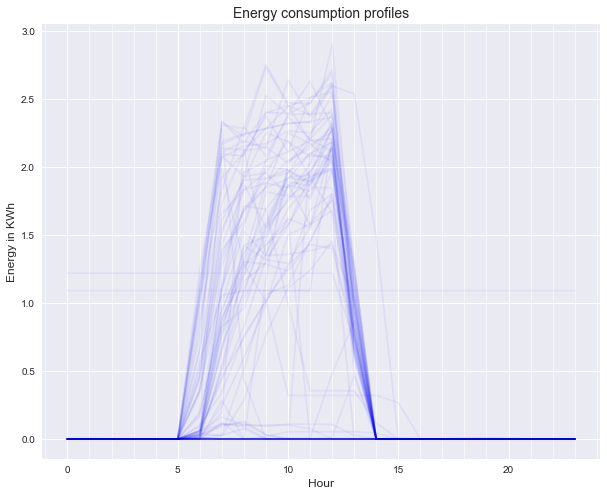

In [84]:
df_pivot = prepare_for_clustering(processed_df,8432,sampling=None)

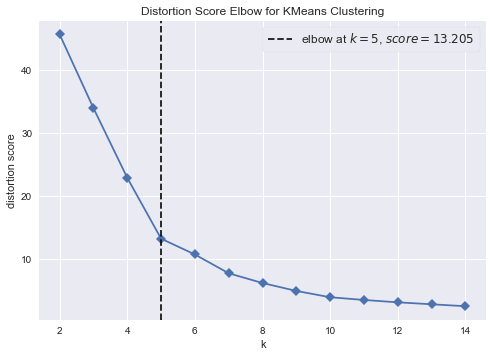

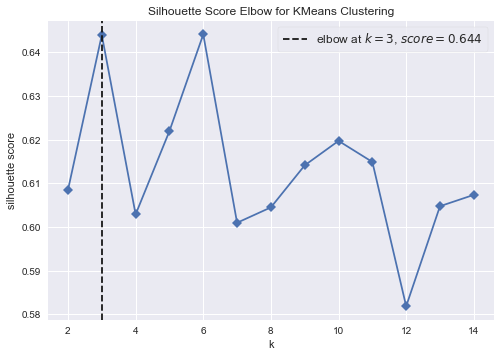

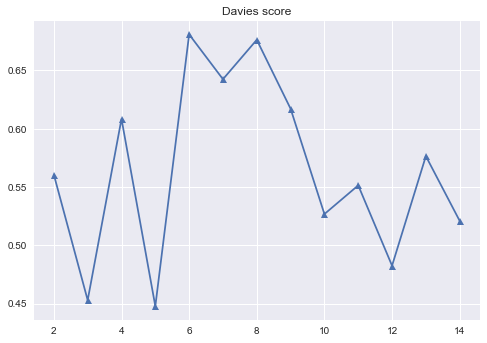

0 blue
1 red
2 green
3 orange


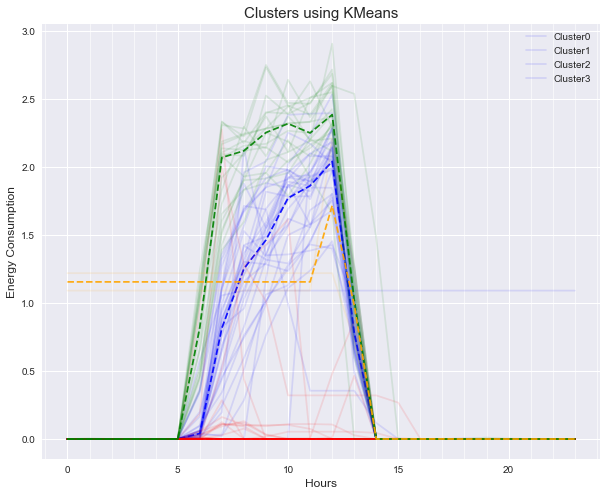

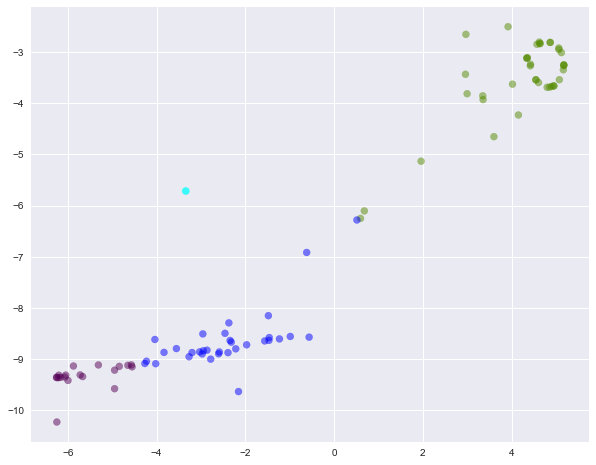

In [85]:
kmeans_clusters = get_clusters(KMeans,df_pivot,4,normalize=True)

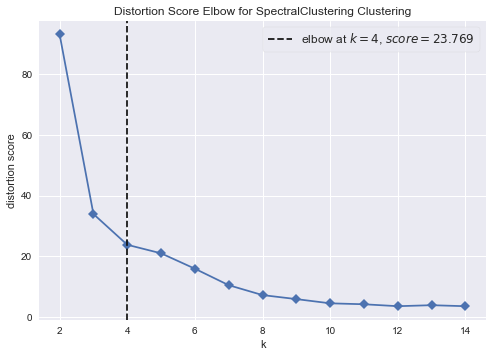

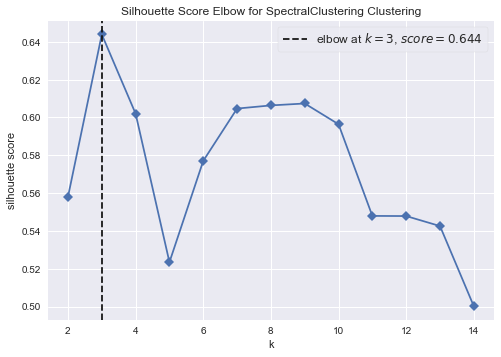

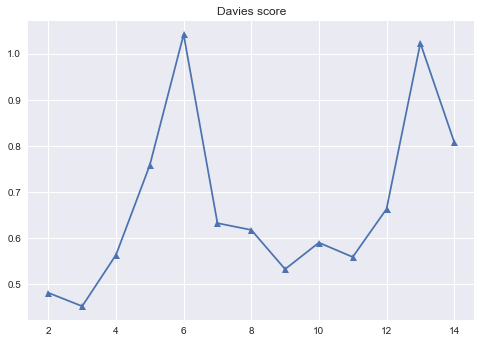

0 blue
1 red
2 green
3 orange
4 black


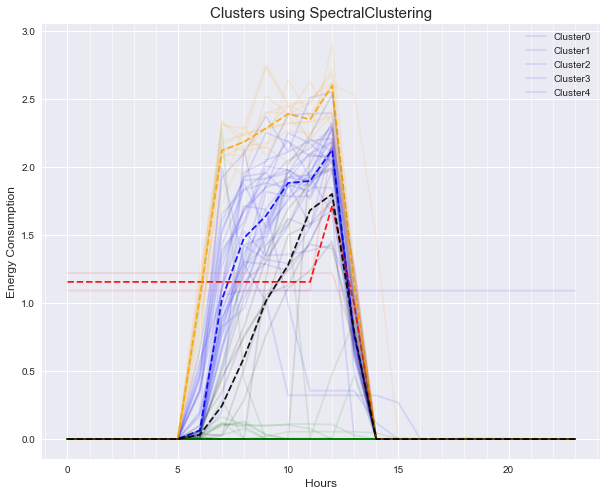

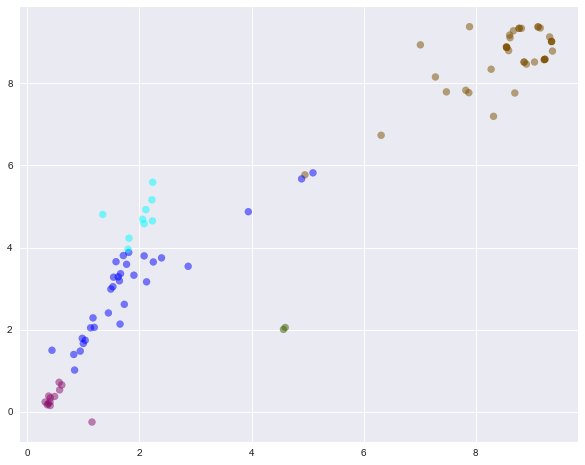

In [86]:
spectral_clusters = get_clusters(SpectralClustering,df_pivot,5,normalize=True)

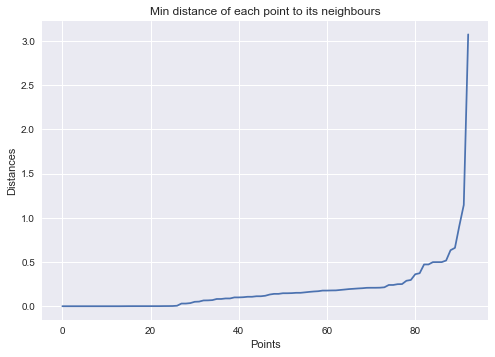

-1 blue
0 red
1 green
2 orange


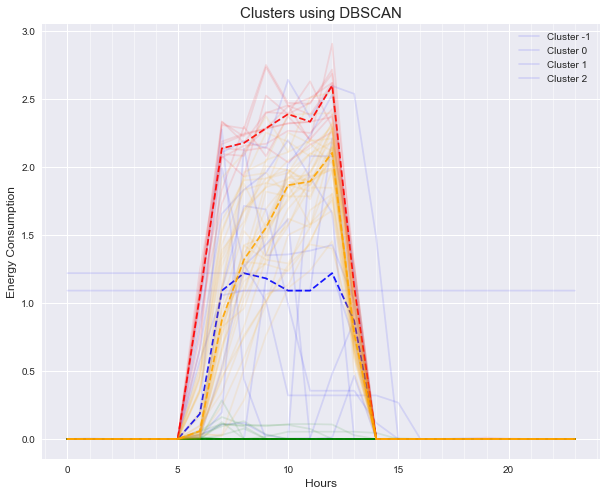

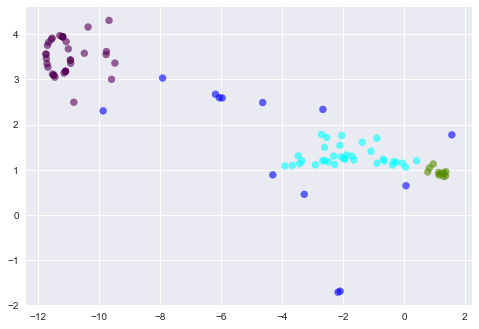

In [97]:
dbscan_clusters = dbscan_cluster(df_pivot,eps=0.3,min_samples=3,normalize=True,eps_list=np.arange(0.1,1.2,0.1))

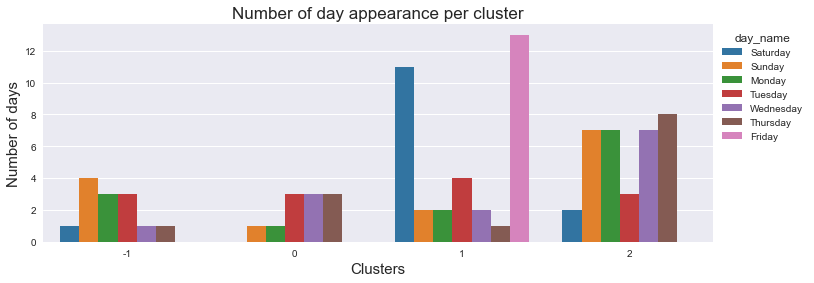

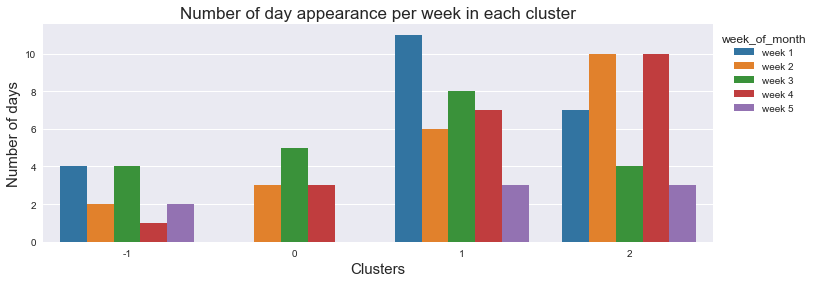

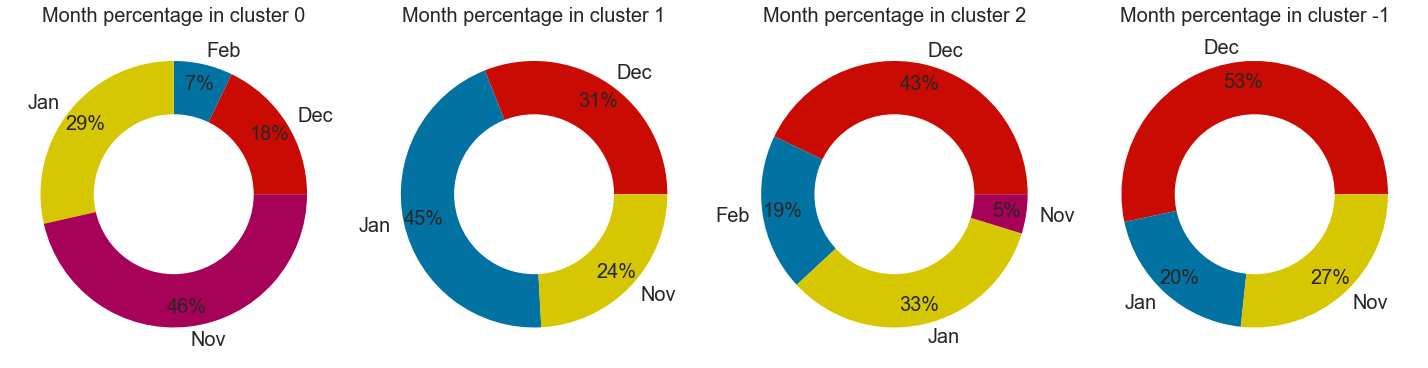

In [98]:
analyse_cluster(dbscan_clusters)